In [1]:
import IPython
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import librosa
import sys ; sys.path.append('../')
from model.network_architecture import autoencoder
from tqdm import tqdm
from evaluacion import *

2021-08-18 23:24:41.715822: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
PESOS = '/home/martin/deep-dereverb/model/ckpts/reales/weights.10-0.008.hdf5'
modelo = autoencoder()
modelo.load_weights(PESOS)

2021-08-17 00:20:27.196477: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-17 00:20:27.250109: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-17 00:20:27.250704: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7715GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2021-08-17 00:20:27.250734: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-17 00:20:27.255643: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-17 00:20:27.255711: I tensorflow/stream_executo

In [5]:
reverb_list = get_audio_list('/home/martin/deep-dereverb/data/train/real/')
clean_list = get_audio_list('/home/martin/deep-dereverb/data/train/clean/')
reverb_list.sort(); clean_list.sort()

In [6]:
audio_in, fs = librosa.load(reverb_list[0], sr=None)
audio_target, fs = librosa.load(clean_list[0], sr=None)
espectro_in, arr_min, arr_max = gen_stft(audio_in)
espectro_target, _, _ = gen_stft(audio_target)

In [7]:
espectro_out = modelo.predict([espectro_in.reshape(1,256,256)])
espectro_out = espectro_out.reshape(256,256)

2021-08-17 00:20:54.791385: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-17 00:20:54.809865: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3199980000 Hz
2021-08-17 00:20:54.995273: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-17 00:20:55.264064: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8202
2021-08-17 00:20:55.802327: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-08-17 00:20:55.802354: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2021-08-17 00:20:55.802831: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-08-17 00:20:55.802876: W tensorflow/stream_executor/gpu/redzone_allocator.cc:31

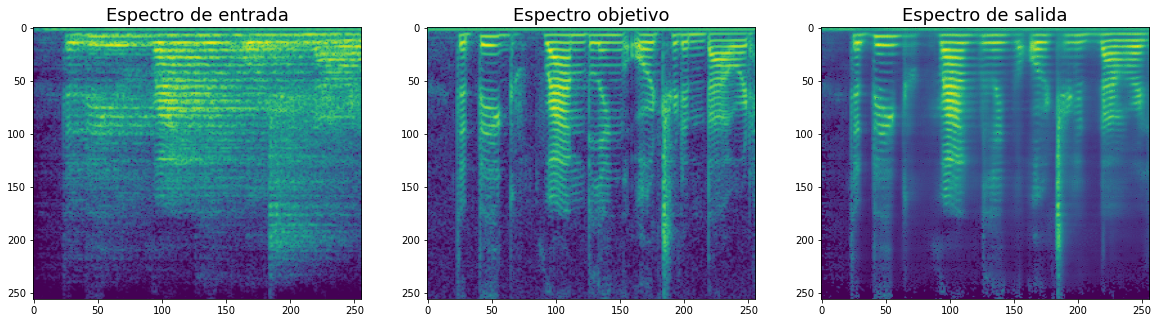

In [9]:
plt.figure(1, figsize=(20,5))
plt.subplot(1,3,1);plt.title('Espectro de entrada', size=18)
plt.imshow(espectro_in, aspect='auto')#;plt.colorbar()
plt.subplot(1,3,2);plt.title('Espectro objetivo', size=18)
plt.imshow(espectro_target, aspect='auto')#;plt.colorbar()
plt.subplot(1,3,3);plt.title('Espectro de salida', size=18)
plt.imshow(espectro_out, aspect='auto')#;plt.colorbar()
plt.savefig('funcionamiento.png')

In [10]:
audio_out = frame_to_raw(espectro_out, arr_min, arr_max)

In [11]:
print('Audio con reverb (entrada)')
IPython.display.display(IPython.display.Audio(audio_in, rate=fs))
print('Audio anecoico (objetivo)')
IPython.display.display(IPython.display.Audio(audio_target, rate=fs))
print('Audio dereverberado (resultado)')
IPython.display.display(IPython.display.Audio(audio_out, rate=fs))

Audio con reverb (entrada)


Audio anecoico (objetivo)


Audio dereverberado (resultado)


# Evaluacion de metricas

In [11]:
CLEAN_PATH = '/home/martin/deep-dereverb/data/test/clean/'
REVERB_PATH = '/home/martin/deep-dereverb/data/test/aug/'
PESOS = '/home/martin/deep-dereverb/model/ckpts/reales/weights.10-0.008.hdf5'
CARPETA = 'resultados/pesos_reales/aug/'

clean_list = get_audio_list(CLEAN_PATH)
reverb_list = get_audio_list(REVERB_PATH)

modelo = autoencoder()
modelo.load_weights(PESOS)

SRMR_reverb = []
SDR_reverb = []
ESTOI_reverb = []

SRMR_dereverb = []
SDR_dereverb = []
ESTOI_dereverb = []

for clean_path, reverb_path in tqdm(zip(clean_list, reverb_list), total=len(clean_list)):
    # Leo los audios de partida
    clean, fs = librosa.load(clean_path, sr=None)
    reverb, fs = librosa.load(reverb_path, sr=None)

    # Aplico el modelo
    espectro_in, arr_min, arr_max = gen_stft(reverb)
    espectro_out = modelo.predict([espectro_in.reshape(1,256,256)])
    espectro_out = espectro_out.reshape(256,256)
    dereverb = frame_to_raw(espectro_out, arr_min, arr_max)
    
    # Calculo las metricas para clean-reverb y clean-dereverb
    srmr, sdr, estoi = get_metricas(clean, reverb, fs)
    SRMR_reverb.append(srmr)
    SDR_reverb.append(sdr)
    ESTOI_reverb.append(estoi)
    
    srmr, sdr, estoi = get_metricas(clean, dereverb, fs)
    SRMR_dereverb.append(srmr)
    SDR_dereverb.append(sdr)
    ESTOI_dereverb.append(estoi)
    
np.save(CARPETA+'/SRMR_reverb.npy', SRMR_reverb)
np.save(CARPETA+'/SDR_reverb.npy', SDR_reverb)
np.save(CARPETA+'/ESTOI_reverb.npy', ESTOI_reverb)

np.save(CARPETA+'/SRMR_dereverb.npy', SRMR_dereverb)
np.save(CARPETA+'/SDR_dereverb.npy', SDR_dereverb)
np.save(CARPETA+'/ESTOI_dereverb.npy', ESTOI_dereverb)

 19%|████████████████▉                                                                       | 1594/8262 [17:02<1:11:44,  1.55it/s]/home/martin/anaconda3/envs/tf/lib/python3.8/site-packages/librosa/core/spectrum.py:1595: RuntimeWarning: overflow encountered in power
  return ref * np.power(10.0, 0.1 * S_db)
/home/martin/anaconda3/envs/tf/lib/python3.8/site-packages/librosa/core/spectrum.py:400: RuntimeWarning: invalid value encountered in multiply
  ytmp = ifft_window * fft.irfft(stft_matrix[:, bl_s:bl_t], axis=0)
 19%|████████████████▉                                                                       | 1594/8262 [17:02<1:11:18,  1.56it/s]


ParameterError: Audio buffer is not finite everywhere

In [55]:
print(reverb_path)
IPython.display.Audio(reverb, rate=16000)

/home/martin/deep-dereverb/data/test/aug/000519.wav


In [54]:
print(clean_path)
IPython.display.Audio(clean, rate=16000)

/home/martin/deep-dereverb/data/test/clean/000519.wav


In [60]:
arr_max

28.915386

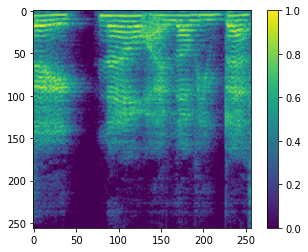

In [57]:
plt.imshow(espectro_in)
plt.colorbar()

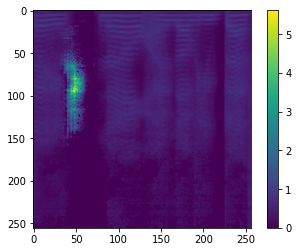

In [58]:
plt.imshow(espectro_out)
plt.colorbar()

In [61]:
frame = denormalise(espectro_out, arr_min, arr_max)
#Escala logaritmica
frame_lin = librosa.db_to_amplitude(frame)

#Necesito agregar el bin de frecuencia que le saque.
frame_lin_pad = np.pad(frame_lin,((0,1),(0,0)), 'minimum')

/home/martin/anaconda3/envs/tf/lib/python3.8/site-packages/librosa/core/spectrum.py:1595: RuntimeWarning: overflow encountered in power
  return ref * np.power(10.0, 0.1 * S_db)


In [69]:
asd = frame_lin
asd[np.isnan(frame_lin)]=0

dtype('float32')

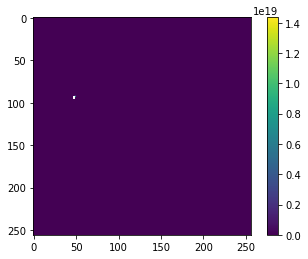

In [70]:
plt.imshow(asd)
plt.colorbar()
frame_lin_pad.dtype

In [35]:
frame_raw = librosa.griffinlim(frame_lin_pad, n_iter=100, hop_length=128,win_length=512)

ParameterError: Audio buffer is not finite everywhere

In [17]:
dereverb = frame_to_raw(espectro_out, arr_min, arr_max)

ParameterError: Audio buffer is not finite everywhere

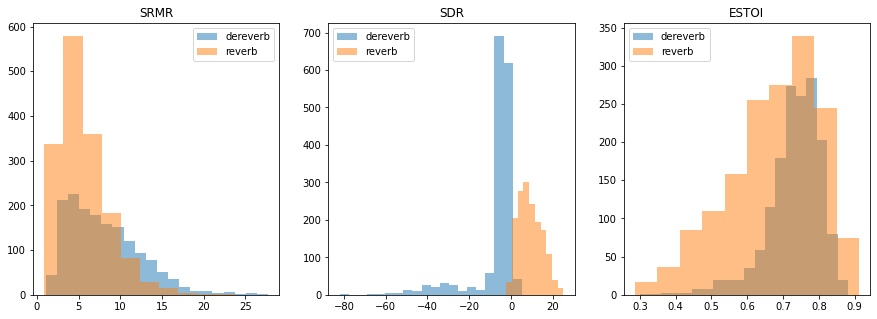

In [74]:
plt.figure(1, figsize=(15,5))
plt.subplot(1,3,1);plt.title('SRMR')
plt.hist(SRMR_dereverb, bins=20, label='dereverb', alpha=0.5); plt.hist(SRMR_reverb, label='reverb', alpha=0.5)
plt.legend()
plt.subplot(1,3,2);plt.title('SDR')
plt.hist(SDR_dereverb, bins=20, label='dereverb',alpha=0.5); plt.hist(SDR_reverb, label='reverb',alpha=0.5)
plt.legend()
plt.subplot(1,3,3);plt.title('ESTOI')
plt.hist(ESTOI_dereverb, bins=20, label='dereverb',alpha=0.5); plt.hist(ESTOI_reverb, label='reverb',alpha=0.5)
plt.legend()